In [1]:
%load_ext autoreload
%autoreload 2

import os
import itertools

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from jaxtyping import Float
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from torch import Tensor
from tqdm.auto import tqdm

from mlpinsoup import MLP, NoisyDataset, evaluate, train

In [ ]:
"""Plotting settings"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update(
    {
        "font.size": 14,
        "axes.labelsize": 15,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "axes.titlesize": 18,
        "figure.titlesize": 19,
    }
)
sns.set_style("whitegrid")

In [3]:
"""Training settings."""

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

p, n_features, d_mlp, rank = 0.01, 100, 50, 50
scale = nn.Parameter(torch.tensor(0.05, device=device))
n_steps = 20_000  # Reduced for faster iteration
align_to_neurons = True

Using GPU: NVIDIA GeForce RTX 3090


In [4]:
@torch.no_grad()
def plot_input_output_heatmap(
    x: float,
    model: MLP,
    ax: plt.Axes | None = None,
    **kwargs,
) -> plt.Axes:
    """Plots heatmap of output response of all features given single-feature input, for all features."""
    device = model.device
    n_features = model.n_features
    title = f"Input-output heatmap (x={x})"

    # Generate one-hot input: each row has exactly one feature set to x
    inputs = torch.eye(n_features, device=device, dtype=torch.float32) * x

    # Generate output response matrix
    outputs = model.forward(inputs)
    outputs_np = outputs.cpu().numpy()

    # Plot it
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Set default parameters
    heatmap_kwargs = {
        "cmap": "viridis",
        "annot": False,
        "fmt": ".2f",
        "vmax": 1,
        "vmin": 0,
        "center": 0,
        "cbar_kws": {"label": "Output value"},
    }
    heatmap_kwargs.update(kwargs)

    ax = sns.heatmap(outputs_np, ax=ax, **heatmap_kwargs)
    ax.set_title(title)
    ax.set_xlabel("Input feature")
    ax.set_ylabel("Output feature")
    ax.set_xticks(np.arange(0, n_features, step=10))
    ax.set_yticks(np.arange(0, n_features, step=10))
    ax.set_xticklabels(np.arange(0, n_features, step=10))
    ax.set_yticklabels(np.arange(0, n_features, step=10))
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="y", rotation=0)

    return ax


In [ ]:
def train_dataset_combination(
    flat_spectrum: bool,
    zero_diagonal: bool,
    exactly_one_active_feature: bool,
    U_equals_V: bool,
    symmetric: bool,
    p: float = 0.01,
    n_features: int = 100,
    d_mlp: int = 50,
    rank: int = 50,
    scale: float = 0.05,
    n_steps: int = 15_000,
    align_to_neurons: bool = True,
    device: str = "cuda",
):
    """Train a model on the specified dataset combination.
    
    Returns:
        tuple: (model, dataset, losses, eval_loss)
    """
    # Print combination
    combo_str = f"flat_spectrum={flat_spectrum}, zero_diagonal={zero_diagonal}, exactly_one_active_feature={exactly_one_active_feature}, U_equals_V={U_equals_V}, symmetric={symmetric}"
    print(f"Training: {combo_str}")

    # Create dataset
    dataset = NoisyDataset(
        n_features=n_features,
        p=p,
        device=device,
        rank=rank,
        scale=nn.Parameter(torch.tensor(scale, device=device)),
        exactly_one_active_feature=exactly_one_active_feature,
        flat_spectrum=flat_spectrum,
        zero_diagonal=zero_diagonal,
        U_equals_V=U_equals_V,
        symmetric=symmetric,
        align_to_neurons=align_to_neurons,
    )

    # Create and train model
    model = MLP(n_features=n_features, d_mlp=d_mlp, device=device)
    losses = train(model, dataset, steps=n_steps)

    # Evaluate model
    eval_loss = evaluate(model, dataset)
    print(f"Final evaluation loss: {eval_loss:.6f}")
    
    return model, dataset, losses, eval_loss


In [12]:
def analyze_and_plot_combination(
    model: MLP,
    dataset: NoisyDataset,
    flat_spectrum: bool,
    zero_diagonal: bool,
    exactly_one_active_feature: bool,
    U_equals_V: bool,
    symmetric: bool,
    n_features: int = 100,
):
    """Generate all three plots for the trained model and dataset.

    Args:
        model: Trained MLP model
        dataset: The dataset used for training
        flat_spectrum, zero_diagonal, exactly_one_active_feature, U_equals_V, symmetric:
            Boolean parameters for plot titles
        n_features: Number of features (for colorbar scaling)
    """
    # Print combination
    combo_str = f"flat_spectrum={flat_spectrum}, zero_diagonal={zero_diagonal}, exactly_one_active_feature={exactly_one_active_feature}, U_equals_V={U_equals_V}, symmetric={symmetric}"
    print(f"Plotting: {combo_str}")

    # Create the plots in 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Top left: Model weights (W_out * W_in)
    ax1 = axes[0, 0]
    model.plot_weight_bars(ax=ax1)
    ax1.set_title("$W_{\\mathrm{out}} \\cdot W_{\\mathrm{in}}$")
    ax1.set_xlabel("Feature Index")
    ax1.set_ylabel("Weight Value")
    ax1.grid(True, alpha=0.3)

    # Top right: Input-output behavior plot (without automatic colorbar)
    ax2 = axes[0, 1]
    # Manually create the input-output behavior plot without the automatic colorbar
    cmap = plt.colormaps.get_cmap("magma")
    for i in range(model.n_features):
        test_input = torch.zeros(1024, model.n_features, device=model.device)
        test_input[:, i] = torch.linspace(-1, 1, 1024, device=model.device)
        test_output = model(test_input).detach()
        c = cmap(i / model.n_features)
        ax2.plot(test_input[:, i].cpu(), test_output[:, i].cpu(), color=c)
    ax2.set_xlabel("Input")
    ax2.set_ylabel("Output")
    ax2.set_title("Input-output behavior")
    ax2.grid(True, alpha=0.3)
    x = torch.linspace(-1, 1, 100)
    ax2.plot(x, F.relu(x), color="tab:red", ls="--", label="ReLU")
    ax2.legend()

    # Add single colorbar for input-output behavior
    norm = Normalize(vmin=0, vmax=n_features)
    sm = ScalarMappable(cmap="magma", norm=norm)
    cbar2 = fig.colorbar(sm, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label("Feature index")

    # Bottom left: Input-output heatmap (x=+1) with its own colorbar
    ax3 = axes[1, 0]
    plot_input_output_heatmap(1.0, model, ax=ax3, cbar=True)
    ax3.set_title("Input-output heatmap (x=+1)")

    # Bottom right: Input-output heatmap (x=-1) with its own colorbar
    ax4 = axes[1, 1]
    plot_input_output_heatmap(-1.0, model, ax=ax4, cbar=True)
    ax4.set_title("Input-output heatmap (x=-1)")

    # Overall title with more spacing from subplots
    fig.suptitle(f"Analysis for: {combo_str}", y=0.97)

    # Adjust layout with padding to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    print("-" * 100)


In [7]:
# Generate all combinations of boolean parameters

boolean_params = [
    "flat_spectrum",
    "zero_diagonal",
    "exactly_one_active_feature",
    "U_equals_V",
    "symmetric",
]

all_combinations = list(itertools.product([True, False], repeat=5))

print(f"Total combinations to analyze: {len(all_combinations)}")
print("Combinations:")
for i, combo in enumerate(all_combinations):
    combo_dict = dict(zip(boolean_params, combo))
    print(f"{i + 1:2d}: {combo_dict}")

# Store results for later analysis if needed
results = {}

Total combinations to analyze: 32
Combinations:
 1: {'flat_spectrum': True, 'zero_diagonal': True, 'exactly_one_active_feature': True, 'U_equals_V': True, 'symmetric': True}
 2: {'flat_spectrum': True, 'zero_diagonal': True, 'exactly_one_active_feature': True, 'U_equals_V': True, 'symmetric': False}
 3: {'flat_spectrum': True, 'zero_diagonal': True, 'exactly_one_active_feature': True, 'U_equals_V': False, 'symmetric': True}
 4: {'flat_spectrum': True, 'zero_diagonal': True, 'exactly_one_active_feature': True, 'U_equals_V': False, 'symmetric': False}
 5: {'flat_spectrum': True, 'zero_diagonal': True, 'exactly_one_active_feature': False, 'U_equals_V': True, 'symmetric': True}
 6: {'flat_spectrum': True, 'zero_diagonal': True, 'exactly_one_active_feature': False, 'U_equals_V': True, 'symmetric': False}
 7: {'flat_spectrum': True, 'zero_diagonal': True, 'exactly_one_active_feature': False, 'U_equals_V': False, 'symmetric': True}
 8: {'flat_spectrum': True, 'zero_diagonal': True, 'exactly_o

### Combination 1

`flat_spectrum=True`  

`zero_diagonal=True`  

`exactly_one_active_feature=True`  

`U_equals_V=True`  

`symmetric=True`  

Training: flat_spectrum=True, zero_diagonal=True, exactly_one_active_feature=True, U_equals_V=True, symmetric=True


Training: 100%|██████████| 10000/10000 [00:14<00:00, 674.97it/s, loss=0.000858]


Final evaluation loss: 0.000804
Plotting: flat_spectrum=True, zero_diagonal=True, exactly_one_active_feature=True, U_equals_V=True, symmetric=True


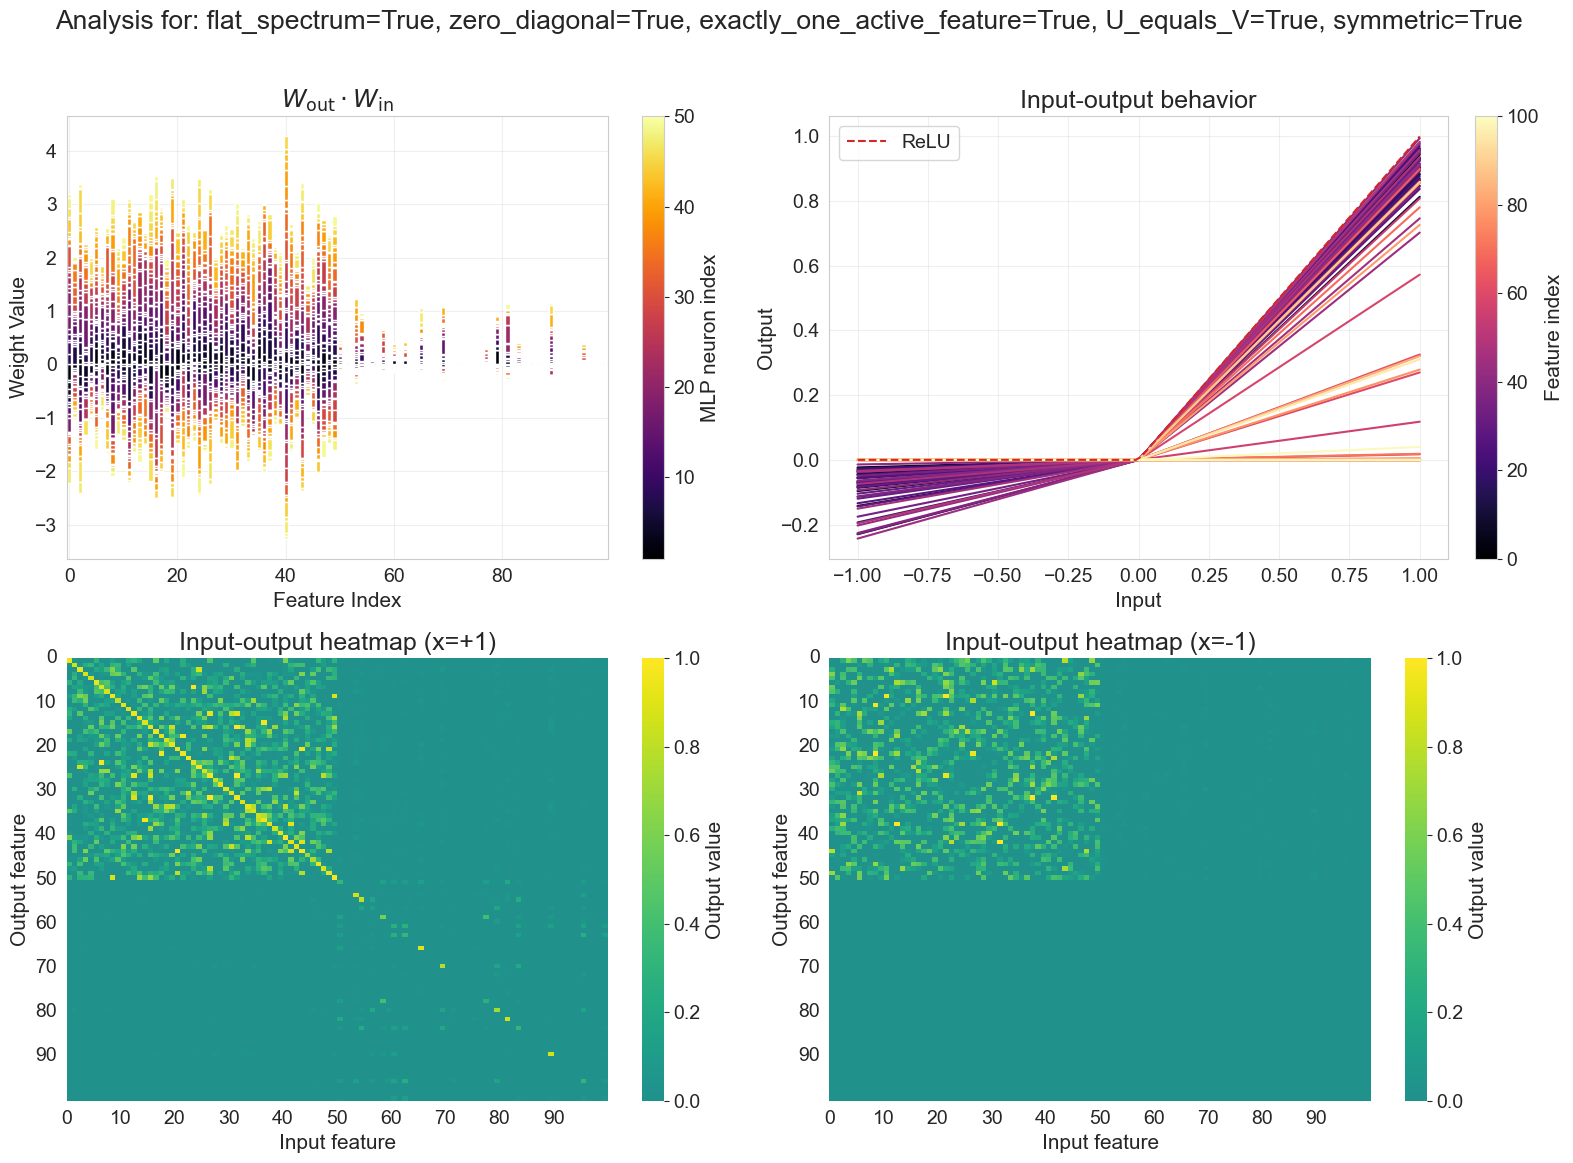

----------------------------------------------------------------------------------------------------


In [ ]:
# Combination 1
model_1, dataset_1, losses_1, eval_loss_1 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_1,
    dataset_1,
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=True,
)

results["combo_1"] = {
    "model": model_1,
    "dataset": dataset_1,
    "losses": losses_1,
    "eval_loss": eval_loss_1,
}

### Combination 2

`flat_spectrum=True`  

`zero_diagonal=True`  

`exactly_one_active_feature=True`  

`U_equals_V=True`  

`symmetric=False`  

In [ ]:
# Combination 2
model_2, dataset_2, losses_2, eval_loss_2 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_2,
    dataset_2,
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=False,
)

results["combo_2"] = {
    "model": model_2,
    "dataset": dataset_2,
    "losses": losses_2,
    "eval_loss": eval_loss_2,
}

### Combination 3

`flat_spectrum=True`  

`zero_diagonal=True`  

`exactly_one_active_feature=True`  

`U_equals_V=False`  

`symmetric=True`

In [ ]:
# Combination 3
model_3, dataset_3, losses_3, eval_loss_3 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_3,
    dataset_3,
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=True,
)

results["combo_3"] = {
    "model": model_3,
    "dataset": dataset_3,
    "losses": losses_3,
    "eval_loss": eval_loss_3,
}

### Combination 4

`flat_spectrum=True`  

`zero_diagonal=True`  

`exactly_one_active_feature=True`  

`U_equals_V=False`  

`symmetric=False`  

In [ ]:
# Combination 4
model_4, dataset_4, losses_4, eval_loss_4 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_4,
    dataset_4,
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=False,
)

results["combo_4"] = {
    "model": model_4,
    "dataset": dataset_4,
    "losses": losses_4,
    "eval_loss": eval_loss_4,
}

### Combination 5

`flat_spectrum=True`  

`zero_diagonal=True`  

`exactly_one_active_feature=False`  

`U_equals_V=True`  

`symmetric=True`  

In [ ]:
# Combination 5
model_5, dataset_5, losses_5, eval_loss_5 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_5,
    dataset_5,
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=True,
)

results["combo_5"] = {
    "model": model_5,
    "dataset": dataset_5,
    "losses": losses_5,
    "eval_loss": eval_loss_5,
}

### Combination 6

`flat_spectrum=True`  

`zero_diagonal=True`  

`exactly_one_active_feature=False`  

`U_equals_V=True`  

`symmetric=False`  

In [ ]:
# Combination 6
model_6, dataset_6, losses_6, eval_loss_6 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_6,
    dataset_6,
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=False,
)

results["combo_6"] = {
    "model": model_6,
    "dataset": dataset_6,
    "losses": losses_6,
    "eval_loss": eval_loss_6,
}

### Combination 7

`flat_spectrum=True`  

`zero_diagonal=True`  

`exactly_one_active_feature=False`  

`U_equals_V=False`  

`symmetric=True`  

In [ ]:
# Combination 7
model_7, dataset_7, losses_7, eval_loss_7 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_7,
    dataset_7,
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=True,
)

results["combo_7"] = {
    "model": model_7,
    "dataset": dataset_7,
    "losses": losses_7,
    "eval_loss": eval_loss_7,
}

### Combination 8

`flat_spectrum=True`  

`zero_diagonal=True`  

`exactly_one_active_feature=False`  

`U_equals_V=False`  

`symmetric=False`  

In [ ]:
# Combination 8
model_8, dataset_8, losses_8, eval_loss_8 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_8,
    dataset_8,
    flat_spectrum=True,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=False,
)

results["combo_8"] = {
    "model": model_8,
    "dataset": dataset_8,
    "losses": losses_8,
    "eval_loss": eval_loss_8,
}

### Combination 9

`flat_spectrum=True`  

`zero_diagonal=False`  

`exactly_one_active_feature=True`  

`U_equals_V=True`  

`symmetric=True`  

In [ ]:
# Combination 9
model_9, dataset_9, losses_9, eval_loss_9 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_9,
    dataset_9,
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=True,
)

results["combo_9"] = {
    "model": model_9,
    "dataset": dataset_9,
    "losses": losses_9,
    "eval_loss": eval_loss_9,
}

### Combination 10

`flat_spectrum=True`  

`zero_diagonal=False`  

`exactly_one_active_feature=True`  

`U_equals_V=True`  

`symmetric=False`  

In [ ]:
# Combination 10
model_10, dataset_10, losses_10, eval_loss_10 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_10,
    dataset_10,
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=False,
)

results["combo_10"] = {
    "model": model_10,
    "dataset": dataset_10,
    "losses": losses_10,
    "eval_loss": eval_loss_10,
}

### Combination 11

`flat_spectrum=True`  

`zero_diagonal=False`  

`exactly_one_active_feature=True`  

`U_equals_V=False`  

`symmetric=True`  

In [ ]:
# Combination 11
model_11, dataset_11, losses_11, eval_loss_11 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_11,
    dataset_11,
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=True,
)

results["combo_11"] = {
    "model": model_11,
    "dataset": dataset_11,
    "losses": losses_11,
    "eval_loss": eval_loss_11,
}

### Combination 12

`flat_spectrum=True`  

`zero_diagonal=False`  

`exactly_one_active_feature=True`  

`U_equals_V=False`  

`symmetric=False`  

In [ ]:
# Combination 12
model_12, dataset_12, losses_12, eval_loss_12 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_12,
    dataset_12,
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=False,
)

results["combo_12"] = {
    "model": model_12,
    "dataset": dataset_12,
    "losses": losses_12,
    "eval_loss": eval_loss_12,
}

### Combination 13

`flat_spectrum=True`  

`zero_diagonal=False`  

`exactly_one_active_feature=False`  

`U_equals_V=True`  

`symmetric=True`  

In [ ]:
# Combination 13
model_13, dataset_13, losses_13, eval_loss_13 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_13,
    dataset_13,
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=True,
)

results["combo_13"] = {
    "model": model_13,
    "dataset": dataset_13,
    "losses": losses_13,
    "eval_loss": eval_loss_13,
}

### Combination 14

`flat_spectrum=True`  

`zero_diagonal=False`  

`exactly_one_active_feature=False`  

`U_equals_V=True`  

`symmetric=False`  

In [ ]:
# Combination 14
model_14, dataset_14, losses_14, eval_loss_14 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_14,
    dataset_14,
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=False,
)

results["combo_14"] = {
    "model": model_14,
    "dataset": dataset_14,
    "losses": losses_14,
    "eval_loss": eval_loss_14,
}

### Combination 15

`flat_spectrum=True`  

`zero_diagonal=False`  

`exactly_one_active_feature=False`  

`U_equals_V=False`  

`symmetric=True`  

In [ ]:
# Combination 15
model_15, dataset_15, losses_15, eval_loss_15 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_15,
    dataset_15,
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=True,
)

results["combo_15"] = {
    "model": model_15,
    "dataset": dataset_15,
    "losses": losses_15,
    "eval_loss": eval_loss_15,
}

### Combination 16

`flat_spectrum=True`  

`zero_diagonal=False`  

`exactly_one_active_feature=False`  

`U_equals_V=False`  

`symmetric=False`  

In [ ]:
# Combination 16
model_16, dataset_16, losses_16, eval_loss_16 = train_dataset_combination(
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_16,
    dataset_16,
    flat_spectrum=True,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=False,
)

results["combo_16"] = {
    "model": model_16,
    "dataset": dataset_16,
    "losses": losses_16,
    "eval_loss": eval_loss_16,
}

### Combination 17

`flat_spectrum=False`  

`zero_diagonal=True`  

`exactly_one_active_feature=True`  

`U_equals_V=True`  

`symmetric=True`  

In [ ]:
# Combination 17
model_17, dataset_17, losses_17, eval_loss_17 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_17,
    dataset_17,
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=True,
)

results["combo_17"] = {
    "model": model_17,
    "dataset": dataset_17,
    "losses": losses_17,
    "eval_loss": eval_loss_17,
}

### Combination 18

`flat_spectrum=False`  

`zero_diagonal=True`  

`exactly_one_active_feature=True`  

`U_equals_V=True`  

`symmetric=False`  

In [ ]:
# Combination 18
model_18, dataset_18, losses_18, eval_loss_18 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_18,
    dataset_18,
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=False,
)

results["combo_18"] = {
    "model": model_18,
    "dataset": dataset_18,
    "losses": losses_18,
    "eval_loss": eval_loss_18,
}

### Combination 19

`flat_spectrum=False`  

`zero_diagonal=True`  

`exactly_one_active_feature=True`  

`U_equals_V=False`  

`symmetric=True`  

In [ ]:
# Combination 19
model_19, dataset_19, losses_19, eval_loss_19 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_19,
    dataset_19,
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=True,
)

results["combo_19"] = {
    "model": model_19,
    "dataset": dataset_19,
    "losses": losses_19,
    "eval_loss": eval_loss_19,
}

### Combination 20

`flat_spectrum=False`  

`zero_diagonal=True`  

`exactly_one_active_feature=True`  

`U_equals_V=False`  

`symmetric=False`  

In [ ]:
# Combination 20
model_20, dataset_20, losses_20, eval_loss_20 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_20,
    dataset_20,
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=False,
)

results["combo_20"] = {
    "model": model_20,
    "dataset": dataset_20,
    "losses": losses_20,
    "eval_loss": eval_loss_20,
}

### Combination 21

`flat_spectrum=False`  

`zero_diagonal=True`  

`exactly_one_active_feature=False`  

`U_equals_V=True`  

`symmetric=True`  

In [ ]:
# Combination 21
model_21, dataset_21, losses_21, eval_loss_21 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_21,
    dataset_21,
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=True,
)

results["combo_21"] = {
    "model": model_21,
    "dataset": dataset_21,
    "losses": losses_21,
    "eval_loss": eval_loss_21,
}

### Combination 22

`flat_spectrum=False`  

`zero_diagonal=True`  

`exactly_one_active_feature=False`  

`U_equals_V=True`  

`symmetric=False`  

In [ ]:
# Combination 22
model_22, dataset_22, losses_22, eval_loss_22 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_22,
    dataset_22,
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=False,
)

results["combo_22"] = {
    "model": model_22,
    "dataset": dataset_22,
    "losses": losses_22,
    "eval_loss": eval_loss_22,
}

### Combination 23

`flat_spectrum=False`  

`zero_diagonal=True`  

`exactly_one_active_feature=False`  

`U_equals_V=False`  

`symmetric=True`  

In [ ]:
# Combination 23
model_23, dataset_23, losses_23, eval_loss_23 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_23,
    dataset_23,
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=True,
)

results["combo_23"] = {
    "model": model_23,
    "dataset": dataset_23,
    "losses": losses_23,
    "eval_loss": eval_loss_23,
}

### Combination 24

`flat_spectrum=False`  

`zero_diagonal=True`  

`exactly_one_active_feature=False`  

`U_equals_V=False`  

`symmetric=False`  

In [ ]:
# Combination 24
model_24, dataset_24, losses_24, eval_loss_24 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_24,
    dataset_24,
    flat_spectrum=False,
    zero_diagonal=True,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=False,
)

results["combo_24"] = {
    "model": model_24,
    "dataset": dataset_24,
    "losses": losses_24,
    "eval_loss": eval_loss_24,
}

### Combination 25

`flat_spectrum=False`  

`zero_diagonal=False`  

`exactly_one_active_feature=True`  

`U_equals_V=True`  

`symmetric=True`  

In [ ]:
# Combination 25
model_25, dataset_25, losses_25, eval_loss_25 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_25,
    dataset_25,
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=True,
)

results["combo_25"] = {
    "model": model_25,
    "dataset": dataset_25,
    "losses": losses_25,
    "eval_loss": eval_loss_25,
}

### Combination 26

`flat_spectrum=False`  

`zero_diagonal=False`  

`exactly_one_active_feature=True`  

`U_equals_V=True`  

`symmetric=False`  

In [ ]:
# Combination 26
model_26, dataset_26, losses_26, eval_loss_26 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_26,
    dataset_26,
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=True,
    symmetric=False,
)

results["combo_26"] = {
    "model": model_26,
    "dataset": dataset_26,
    "losses": losses_26,
    "eval_loss": eval_loss_26,
}

### Combination 27

`flat_spectrum=False`  

`zero_diagonal=False`  

`exactly_one_active_feature=True`  

`U_equals_V=False`  

`symmetric=True`  

In [ ]:
# Combination 27
model_27, dataset_27, losses_27, eval_loss_27 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_27,
    dataset_27,
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=True,
)

results["combo_27"] = {
    "model": model_27,
    "dataset": dataset_27,
    "losses": losses_27,
    "eval_loss": eval_loss_27,
}

### Combination 28

`flat_spectrum=False`  

`zero_diagonal=False`  

`exactly_one_active_feature=True`  

`U_equals_V=False`  

`symmetric=False`  

In [ ]:
# Combination 28
model_28, dataset_28, losses_28, eval_loss_28 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_28,
    dataset_28,
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=True,
    U_equals_V=False,
    symmetric=False,
)

results["combo_28"] = {
    "model": model_28,
    "dataset": dataset_28,
    "losses": losses_28,
    "eval_loss": eval_loss_28,
}

### Combination 29

`flat_spectrum=False`  

`zero_diagonal=False`  

`exactly_one_active_feature=False`  

`U_equals_V=True`  

`symmetric=True`  

In [ ]:
# Combination 29
model_29, dataset_29, losses_29, eval_loss_29 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_29,
    dataset_29,
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=True,
)

results["combo_29"] = {
    "model": model_29,
    "dataset": dataset_29,
    "losses": losses_29,
    "eval_loss": eval_loss_29,
}

### Combination 30

`flat_spectrum=False`  

`zero_diagonal=False`  

`exactly_one_active_feature=False`  

`U_equals_V=True`  

`symmetric=False`  

In [ ]:
# Combination 30
model_30, dataset_30, losses_30, eval_loss_30 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_30,
    dataset_30,
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=True,
    symmetric=False,
)

results["combo_30"] = {
    "model": model_30,
    "dataset": dataset_30,
    "losses": losses_30,
    "eval_loss": eval_loss_30,
}

### Combination 31

`flat_spectrum=False`  

`zero_diagonal=False`  

`exactly_one_active_feature=False`  

`U_equals_V=False`  

`symmetric=True`  

In [ ]:
# Combination 31
model_31, dataset_31, losses_31, eval_loss_31 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=True,
    device=device,
)

analyze_and_plot_combination(
    model_31,
    dataset_31,
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=True,
)

results["combo_31"] = {
    "model": model_31,
    "dataset": dataset_31,
    "losses": losses_31,
    "eval_loss": eval_loss_31,
}

### Combination 32

`flat_spectrum=False`  

`zero_diagonal=False`  

`exactly_one_active_feature=False`  

`U_equals_V=False`  

`symmetric=False`  

In [ ]:
# Combination 32
model_32, dataset_32, losses_32, eval_loss_32 = train_dataset_combination(
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=False,
    device=device,
)

analyze_and_plot_combination(
    model_32,
    dataset_32,
    flat_spectrum=False,
    zero_diagonal=False,
    exactly_one_active_feature=False,
    U_equals_V=False,
    symmetric=False,
)

results["combo_32"] = {
    "model": model_32,
    "dataset": dataset_32,
    "losses": losses_32,
    "eval_loss": eval_loss_32,
}

## Summary Analysis

In [ ]:
# Summary of all combinations
print("Summary of evaluation losses for all combinations:")
print("=" * 80)
for combo_name, result in results.items():
    combo_num = int(combo_name.split("_")[1])
    combo = all_combinations[combo_num - 1]
    combo_dict = dict(zip(boolean_params, combo))
    print(f"{combo_name}: {result['eval_loss']:.6f} - {combo_dict}")

# Find best and worst performing combinations
eval_losses = [(combo_name, result["eval_loss"]) for combo_name, result in results.items()]
eval_losses.sort(key=lambda x: x[1])

print("\n" + "=" * 80)
print("Best performing combinations (lowest loss):")
for i in range(min(5, len(eval_losses))):
    combo_name, loss = eval_losses[i]
    combo_num = int(combo_name.split("_")[1])
    combo = all_combinations[combo_num - 1]
    combo_dict = dict(zip(boolean_params, combo))
    print(f"{i + 1}. {combo_name}: {loss:.6f} - {combo_dict}")

print("\nWorst performing combinations (highest loss):")
for i in range(min(5, len(eval_losses))):
    combo_name, loss = eval_losses[-(i + 1)]
    combo_num = int(combo_name.split("_")[1])
    combo = all_combinations[combo_num - 1]
    combo_dict = dict(zip(boolean_params, combo))
    print(f"{i + 1}. {combo_name}: {loss:.6f} - {combo_dict}")